# Spring 2022
# CPSC 585 Project 5
## Raymond Carpio
## Yu Pan
## Sijie Shang
## John Tu

#1. Begin with the Keras example Collaborative Filtering for Movie Recommendations and verify that you can obtain the sample examples.
This example uses the Keras Embedding layer type. While it may not be clear from the documentation, this layer type can be used to build an autoencoder. For example, to build the basic autoencoder of Figure 2.7 on p. 73 of the textbook, you could stack together an Embedding layer with input_dim 5 and output_dim 3 with another Embedding layer with input_dim 3 and output_dim 5.

While this could obviously be done instead using a single Dense hidden layer, the difference is that Embedding layers work well with sparse data (e.g. where users have not rated most movies in the dataset.)

As a result, the model corresponds roughly to the matrix factorization shown in Figure 2.13 on p. 84 of the textbook, using the dot product to compute the similarity of the user and movie vectors.


In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

991232/978202 [==============================] - 0s 0us/step
Extracting all the files now...
Done!


In [ ]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [ ]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)
model.summary()

Epoch 1/5
1418/1418 [==============================] - 19s 12ms/step - loss: 0.6355 - val_loss: 0.6207
Epoch 2/5
1418/1418 [==============================] - 19s 14ms/step - loss: 0.6134 - val_loss: 0.6163
Epoch 3/5
1418/1418 [==============================] - 19s 13ms/step - loss: 0.6084 - val_loss: 0.6163
Epoch 4/5
1418/1418 [==============================] - 16s 11ms/step - loss: 0.6080 - val_loss: 0.6142
Epoch 5/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6080 - val_loss: 0.6137
Model: "recommender_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  30500     
                                                                 
 embedding_1 (Embedding)     multiple                  610       
                                                                 
 embedding_2 (Embedding)     multiple                  486200    


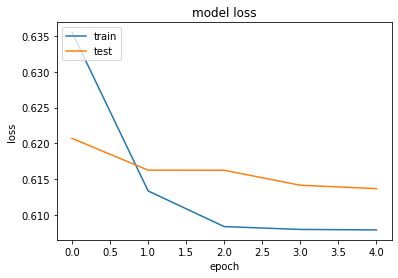

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
#print(movies_watched_by_user)

def recommender_1(movies_watched_by_user):
    movies_not_watched = movie_df[
        ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
    ]["movieId"]
    movies_not_watched = list(
        set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
    )
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

    user_encoder = user2user_encoded.get(user_id)
    user_movie_array = np.hstack(
        ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
    )
    ratings = model.predict(user_movie_array).flatten()
    top_ratings_indices = ratings.argsort()[-10:][::-1]
    recommended_movie_ids = [
        movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
    ]

    print("Showing recommendations for user: {}".format(user_id))
    print("====" * 9)
    print("Movies with high ratings from user")
    print("----" * 8)
    top_movies_user = (
        movies_watched_by_user.sort_values(by="rating", ascending=False)
        .head(5)
        .movieId.values
    )
    movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
    for row in movie_df_rows.itertuples():
        print(row.title, ":", row.genres)

    print("----" * 8)
    print("Top 10 movie recommendations")
    print("----" * 8)
    recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
    for row in recommended_movies.itertuples():
        print(row.title, ":", row.genres)
recommender_1(movies_watched_by_user)

Showing recommendations for user: 212
Movies with high ratings from user
--------------------------------
Fight Club (1999) : Action|Crime|Drama|Thriller
Moonrise Kingdom (2012) : Comedy|Drama|Romance
Gifted (2017) : Drama
Three Billboards Outside Ebbing, Missouri (2017) : Crime|Drama
Isle of Dogs (2018) : Animation|Comedy
--------------------------------
Top 10 movie recommendations
--------------------------------
Rear Window (1954) : Mystery|Thriller
One Flew Over the Cuckoo's Nest (1975) : Drama
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Lawrence of Arabia (1962) : Adventure|Drama|War
Apocalypse Now (1979) : Action|Drama|War
Goodfellas (1990) : Crime|Drama
Godfather: Part II, The (1974) : Crime|Drama
Full Metal Jacket (1987) : Drama|War
Amadeus (1984) : Drama
Cool Hand Luke (1967) : Drama


#2. Construct a feature vector for one or more members of your team, choosing and rating several movies that they have seen. (Do not rate all movies that they have seen — leave room for recommendations.)
#What other movies does the network recommend? How many of the recommended movies have they actually seen? Were the recommendations accurate?


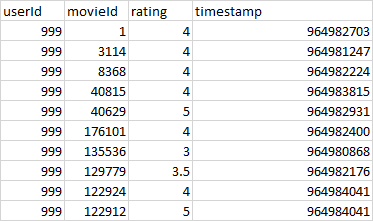

In [ ]:
rated_movies = {'userId': [999,999,999,999,999,999,999,999,999,999], 'movieId': [1,3114,8368,40815,40629,176101,135536,129779,122924,122912], 'rating': [4,4,4,4,5,4,3,3.5,4,5]}
movies_watched_by_user = pd.DataFrame(rated_movies)
recommender_1(movies_watched_by_user)

Showing recommendations for user: 212
Movies with high ratings from user
--------------------------------
Toy Story (1995) : Adventure|Animation|Children|Comedy|Fantasy
Toy Story 2 (1999) : Adventure|Animation|Children|Comedy|Fantasy
Harry Potter and the Prisoner of Azkaban (2004) : Adventure|Fantasy|IMAX
Pride & Prejudice (2005) : Drama|Romance
Avengers: Infinity War - Part I (2018) : Action|Adventure|Sci-Fi
--------------------------------
Top 10 movie recommendations
--------------------------------
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
Shawshank Redemption, The (1994) : Crime|Drama
Rear Window (1954) : Mystery|Thriller
One Flew Over the Cuckoo's Nest (1975) : Drama
Star Wars: Episode V - The Empire Strikes Back (1980) : Action|Adventure|Sci-Fi
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) : Action|Adventure
Goodfellas (1990) : Crime|Drama
Godfather: Part II, The (1974) 

## A: Based on the user's watch history, the genres that are relevant in the recommendations list are Adventure and Fantasy. Thus, the recommendations are not as accurate as they appear since the most common genres that appear are Crime and Drama.

#3. While the matrix factorization model described in the textbook relies on only a single dense hidden layer (or equivalently, two hidden embedding layers), it should be possible to achieve better results with a deeper network.
#Replace the dot product with one or more dense layers, allowing the network to learn relationships between the user and movie vectors. Compare the performance of the network on the training and validation sets.


In [ ]:
# Instead of modifying the existing model from Problem 1, build a new model with a Dense hidden layer.
model2 = tf.keras.Sequential()
model2.add(tf.keras.Input(shape=(2,)))
model2.add(tf.keras.layers.Dense(200, activation="relu", name="HiddenLayer"))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(1, activation="sigmoid", name="OutputLayer"))

model2.summary()
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HiddenLayer (Dense)         (None, 200)               600       
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 OutputLayer (Dense)         (None, 1)                 201       
                                                                 
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model2.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 6s 3ms/step - loss: 1.5668 - val_loss: 0.6662
Epoch 2/5
1418/1418 [==============================] - 4s 3ms/step - loss: 1.3179 - val_loss: 0.8971
Epoch 3/5
1418/1418 [==============================] - 3s 2ms/step - loss: 1.3115 - val_loss: 0.6984
Epoch 4/5
1418/1418 [==============================] - 4s 3ms/step - loss: 1.1437 - val_loss: 0.6409
Epoch 5/5
1418/1418 [==============================] - 4s 3ms/step - loss: 1.1386 - val_loss: 0.6512


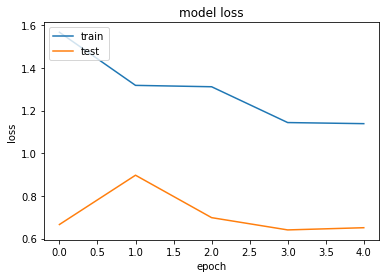

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
# Follow the same procedure from Problem 1, except try a different user id.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
#print(movies_watched_by_user)

def recommender_2(movies_watched_by_user):
    movies_not_watched = movie_df[
        ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
    ]["movieId"]
    movies_not_watched = list(
        set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
    )
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

    user_encoder = user2user_encoded.get(user_id)
    user_movie_array = np.hstack(
        ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
    )
    ratings = model2.predict(user_movie_array).flatten()
    top_ratings_indices = ratings.argsort()[-10:][::-1]
    recommended_movie_ids = [
        movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
    ]

    print("Showing recommendations for user: {}".format(user_id))
    print("====" * 9)
    print("Movies with high ratings from user")
    print("----" * 8)
    top_movies_user = (
        movies_watched_by_user.sort_values(by="rating", ascending=False)
        .head(5)
        .movieId.values
    )
    movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
    for row in movie_df_rows.itertuples():
        print(row.title, ":", row.genres)

    print("----" * 8)
    print("Top 10 movie recommendations")
    print("----" * 8)
    recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
    for row in recommended_movies.itertuples():
        print(row.title, ":", row.genres)
recommender_2(movies_watched_by_user)

Showing recommendations for user: 517
Movies with high ratings from user
--------------------------------
Four Weddings and a Funeral (1994) : Comedy|Romance
101 Dalmatians (1996) : Adventure|Children|Comedy
Gosford Park (2001) : Comedy|Drama|Mystery
Polar Express, The (2004) : Adventure|Animation|Children|Fantasy|IMAX
Up (2009) : Adventure|Animation|Children|Drama
--------------------------------
Top 10 movie recommendations
--------------------------------
Mummy, The (1999) : Action|Adventure|Comedy|Fantasy|Horror|Thriller
Star Wars: Episode I - The Phantom Menace (1999) : Action|Adventure|Sci-Fi
Superman (1978) : Action|Adventure|Sci-Fi
Superman II (1980) : Action|Sci-Fi
Dracula (1931) : Horror
Frankenstein (1931) : Drama|Horror|Sci-Fi
Wolf Man, The (1941) : Drama|Fantasy|Horror
Rocky Horror Picture Show, The (1975) : Comedy|Horror|Musical|Sci-Fi
Run Lola Run (Lola rennt) (1998) : Action|Crime
South Park: Bigger, Longer and Uncut (1999) : Animation|Comedy|Musical


In [ ]:
# This snippet of code is imported from problem 2, and will be used to compare results for problem 3.
rated_movies = {'userId': [999,999,999,999,999,999,999,999,999,999], 'movieId': [1,3114,8368,40815,40629,176101,135536,129779,122924,122912], 'rating': [4,4,4,4,5,4,3,3.5,4,5]}
movies_watched_by_user = pd.DataFrame(rated_movies)
recommender_2(movies_watched_by_user)

Showing recommendations for user: 517
Movies with high ratings from user
--------------------------------
Toy Story (1995) : Adventure|Animation|Children|Comedy|Fantasy
Toy Story 2 (1999) : Adventure|Animation|Children|Comedy|Fantasy
Harry Potter and the Prisoner of Azkaban (2004) : Adventure|Fantasy|IMAX
Pride & Prejudice (2005) : Drama|Romance
Avengers: Infinity War - Part I (2018) : Action|Adventure|Sci-Fi
--------------------------------
Top 10 movie recommendations
--------------------------------
Star Wars: Episode I - The Phantom Menace (1999) : Action|Adventure|Sci-Fi
Superman (1978) : Action|Adventure|Sci-Fi
Superman II (1980) : Action|Sci-Fi
Dracula (1931) : Horror
Frankenstein (1931) : Drama|Horror|Sci-Fi
Wolf Man, The (1941) : Drama|Fantasy|Horror
Rocky Horror Picture Show, The (1975) : Comedy|Horror|Musical|Sci-Fi
Run Lola Run (Lola rennt) (1998) : Action|Crime
South Park: Bigger, Longer and Uncut (1999) : Animation|Comedy|Musical
Ghostbusters (a.k.a. Ghost Busters) (1984)

## Based on the training and validation loss obtained after the training step, the model with the Dense layer did much worse than the model from Experiment 1 as seen in the graph above, where the training loss never dropped below 1.0, and the validation loss did not indicate a clear pattern of convergence.

#4. Compare the quality of the recommendations from experiment (2) with those of the new network of experiment (3). Does the recommendation performance improve for the members of your team?


## A: The recommendations from experiment 2 shows Crime and Drama movies as the top 10 recommedations, while 2 of the 5 movies watched by the user have Crime and Drama as their main genres. For experiment 3, the movies that the first user watched are primarily Comedy movies, and out of the 10 recommended movies, 3 of them have Comedy. For the second user, Adventure and Fantasy are their top genres, and the top 10 recommendations included only two Adventure movies and one Fantasy movie. Thus, based on the results obtained, the recommendation performance has not improved.

#5. If you were disappointed by the results of experiments (3) and (4), your network may be suffering from the problem shown in Figure 2.11 on p. 79 of the textbook, where the hidden layers do a poor job mapping out-of-sample data points to reduced representations. This is exactly the problem addressed by variational autoencoders.
#Use the Keras example Variational AutoEncoder to add an additional sampling layer to your network.
Note: although much of the code is specific to building a convolutional VAE, you will also need to customize the training process as shown in the example in order to implement the loss function of Equations 4.17 through 4.19 on p. 208 of the textbook.
#Compare the performance of this network with those in experiments (1) and (3).


In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 2
# Instead of modifying the existing model from Problem 1, build a new model with a Dense hidden layer.
encoder_inputs = keras.Input(shape=(50, 610, 1))
#encoder.add(tf.keras.Input(shape=(2,)))
x = tf.keras.layers.Dense(200, activation="relu", name="HiddenLayer")(encoder_inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1, activation="sigmoid", name="OutputLayer")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()
#encoder.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001))

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 610, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 HiddenLayer (Dense)            (None, 50, 610, 200  400         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 flatten_1 (Flatten)            (None, 6100000)      0           ['HiddenLayer[0][0]']            
                                                                                            

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(50 *610 *200, activation="sigmoid")(latent_inputs)
x = layers.Reshape((50, 610, 200))(x)
decoder_outputs = tf.keras.layers.Dense(200, activation="relu", name="OutputLayer")(x)
#decoder_outputs = layers.Dense(1, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 6100000)           18300000  
                                                                 
 reshape (Reshape)           (None, 50, 610, 200)      0         
                                                                 
 OutputLayer (Dense)         (None, 50, 610, 200)      40200     
                                                                 
Total params: 18,340,200
Trainable params: 18,340,200
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
print(x_train.shape)
print(y_train.shape)

(90752, 2)
(90752,)


In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
#vae.fit(x_train, y_train, epochs=30, batch_size=128) # Do not uncomment, as the error will be thrown!

## Since we are unable to figure out how to implement the Variational Autoencoder model for the recommendation system, we are unable to proceed further past the training process.